# Calculate sigmav vs. mDM for simulated DM datasets

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle

from gammapy.maps import MapAxis, RegionNDMap
from gammapy.modeling.models import PointSpatialModel
from gammapy.modeling.models import SkyModel, Models
from gammapy.astro.darkmatter.utils import SigmaVEstimator, DMDatasetOnOff
from gammapy.astro.darkmatter import DarkMatterAnnihilationSpectralModel
from gammapy.irf import load_cta_irfs

## Define parameters for simulated observation

In [2]:
# -
livetime = 300 * u.h # in hours
offset = 0.5 * u.deg
FOVLON=0 * u.deg
FOVLAT=0 * u.deg

# Energy from 0.01 to 100 TeV with 20 bins/decade
energy = np.logspace(-1.8, 1.5, 20) * u.TeV

# Energy true wider range and higher number of bins
energy_true = np.logspace(-2, 2, 100) * u.TeV

# DMAnnihilation Model
JFAC = 1.42e19 * u.Unit("GeV2 cm-5") # Draco from Aguirre-Santaella+20
mDM = 1000*u.Unit("GeV")
channel = "b"
redshift = 0

## Build IRFs with the defined parameters

In [3]:
# Load IRFs
filename = (
    "$GAMMAPY_DATA/prod3b-v1/bcf/North_z20_average_50h/irf_file.fits"
)
cta_irf = load_cta_irfs(filename)

NDDataArray summary info
MapAxis

	name       : energy_true
	unit       : 'TeV'     
	nbins      : 42        
	node type  : edges     
	edges min  : 1.3e-02 TeV
	edges max  : 2.0e+02 TeV
	interp     : log       
MapAxis

	name       : offset    
	unit       : 'deg'     
	nbins      : 6         
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 6.0e+00 deg
	interp     : lin       
Data           : size =   252, min =  0.000 m2, max = 1303965.500 m2



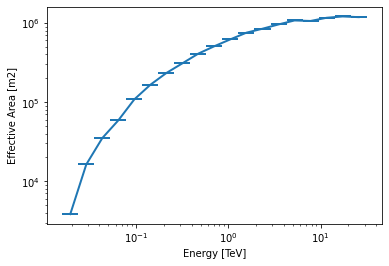

In [4]:
aeff = cta_irf["aeff"].to_effective_area_table(offset=offset, energy=energy)
aeff.plot()
plt.loglog()
print(cta_irf["aeff"].data)

In [5]:
#edisp = cta_irf["edisp"].to_energy_dispersion(
#    offset=offset, e_true=energy_true, e_reco=energy
#)
#edisp.plot_matrix()
#print(edisp.data)

## Build the background counts from PSF and IRF background

In [6]:
containment = 0.68
energies = np.sqrt(energy[1:] * energy[:-1])
psf = cta_irf["psf"].to_energy_dependent_table_psf(theta=offset)
on_radii = psf.containment_radius(energy=energies, fraction=containment)
solid_angles = 2 * np.pi * (1 - np.cos(on_radii)) * u.sr

#
aeff.data.data *= containment

In [7]:
bkg_data = cta_irf["bkg"].evaluate_integrate(
    fov_lon=FOVLON, fov_lat=FOVLAT, energy_reco=energy
)
axis = MapAxis.from_nodes(energies * u.TeV, interp="log", name="energy")
bkg = RegionNDMap.create(f"icrs;circle({FOVLON.value}, {FOVLAT.value}, {offset.value})", axes=[axis])
bkg.quantity = (bkg_data * solid_angles).to_value("h-1")*livetime.value

#bkg = CountsSpectrum(
#    energy[:-1],
#    energy[1:],
#    data=(bkg_data * solid_angles).to_value("h-1")*livetime
#)

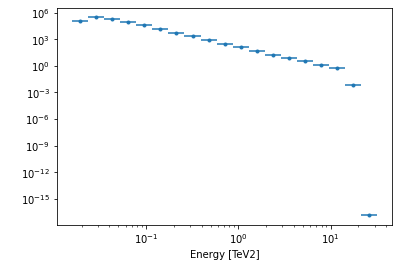

In [8]:
bkg.plot()

## Simulate OnOff observation with DM emission model

In [9]:
# DM Spatial Component
spatial_model = PointSpatialModel(
    lon_0="260.05 deg", lat_0="57.915 deg", frame="icrs"
)

In [10]:
# DM Flux
spectral_model = DarkMatterAnnihilationSpectralModel(
    mass=mDM, 
    channel=channel, 
    jfactor=JFAC, 
    z=redshift
)

In [11]:
from gammapy.modeling.models import Absorption, AbsorbedSpectralModel
absorption_model = Absorption.read_builtin('dominguez')
spectral_model = AbsorbedSpectralModel(spectral_model, absorption_model, redshift)

In [12]:
sky_model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)
models = Models([sky_model])

In [13]:
dataset = DMDatasetOnOff(
    counts=bkg,
    aeff=aeff,
    models=models,
    livetime=livetime,
    acceptance=1,
    acceptance_off=3
)

In [14]:
nuisance = dict(
    j=JFAC,
    jobs=JFAC,
    sigmaj=0.3*JFAC,
    sigmatau=0.01,
    # width=5 # default value / optional param 
)
dataset.nuisance = nuisance

## The SigmaVEstimator

**Enable inspection**

In [15]:
#import logging
#logging.basicConfig()
#logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("WARNING")
#logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("DEBUG")
import warnings

**Instatiate estimator**

In [16]:
masses = [100, 200, 500, 1000, 5000, 10000, 50000]*u.GeV
channels = ["b", "tau", "Z"] 
estimator = SigmaVEstimator(dataset, masses, channels)

**Run estimator and fetch results**

In [32]:
%%time
# stat_profile_opts=dict(bounds=(-25, 100), nvalues=50)     # default param
# if nuisance = True the process takes the nuisance parameters into account
warnings.filterwarnings("ignore")
result = estimator.run(runs=5, nuisance=True)

Wider range needed in likelihood profile
Skipping run 0
Wider range needed in likelihood profile
Skipping run 3
Wider range needed in likelihood profile
Skipping run 4


CPU times: user 10min 39s, sys: 3.68 s, total: 10min 43s
Wall time: 11min 1s


**Display results for channel b and run 1**

In [33]:
cols = ["mass", "sigma_v", "sv_ul", "sv_best", "j_best"]
result["runs"]["b"][2][cols]

mass,sigma_v,sv_ul,sv_best,j_best
GeV,cm3 / s,,,GeV2 / cm5
float64,float64,float64,float64,float64
100.0,1.3743082464472707e-24,45.81027488157569,7.541482064439525,2.8434652255516602e+19
200.0,1.6577617088727736e-24,55.25872362909245,1.0,1.42e+19
500.0,8.1404988098731005e-25,27.134996032910333,1.0,1.42e+19
1000.0,2.1070322978456536e-25,7.023440992818845,0.0,3.3902465412834603e+19
5000.0,2.177491963269261e-25,7.258306544230869,0.0,3.019264720449407e+19
10000.0,5.699133793877554e-25,18.99711264625851,1.0,1.42e+19
50000.0,6.114826757159698e-25,20.382755857198994,1.0,1.42e+19


**Plot likelihood profile for a specific fit**

In [34]:
idx = np.argwhere(masses.value==100)
profile = result["runs"]["Z"][2]["statprofile"][idx][0][0]

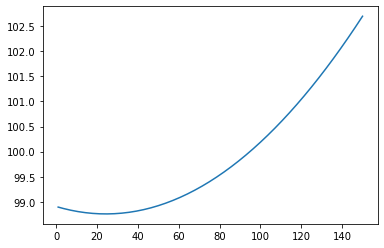

In [35]:
plt.plot(profile["values"], profile["stat"]);

## Obtained results

In [36]:
result["mean"]["b"]

mass,sigma_v,sigma_v_std,jfactor,jfactor_std
GeV,cm3 / s,cm3 / s,GeV2 / cm5,GeV2 / cm5
float64,float64,float64,float64,float64
100.0,2.2200139435091753e-24,8.457056970619046e-25,2.2691024886293484e+19,7.119986802282495e+18
200.0,1.371405179074919e-24,2.8635652979785454e-25,1.8249533589232753e+19,4.996817990225978e+18
500.0,8.964896186499732e-25,8.243973766266305e-26,1.7168024859896015e+19,4.937656661431766e+18
1000.0,4.4285805417710595e-25,2.321548243925406e-25,2.17682017962386e+19,9.013055107641071e+18
5000.0,4.380857254477142e-25,2.203365291207881e-25,2.2957189012760908e+19,8.399186571695421e+18
10000.0,5.273095974000512e-25,4.260378198770423e-26,1.42e+19,0.0
50000.0,5.366159922485212e-25,7.486668346744862e-26,1.42e+19,0.0


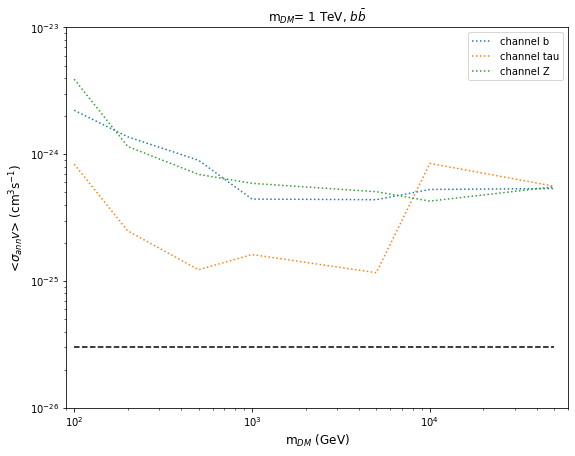

In [37]:
plt.figure(figsize=(9,7))
plt.ylim(1e-26, 1e-23)
plt.xlim(90, 60000)
plt.ylabel(r"<$\sigma_{ann}v$> (cm$^3$s$^{-1}$)", fontsize=12)
plt.xlabel("m$_{DM}$ (GeV)", fontsize=12)
plt.title(r'm$_{DM}$= 1 TeV, $b\bar{b}$')
plt.hlines(3e-26, 100, 50000, ls="--")


for ch in channels:
    plt.loglog(
        result["mean"][ch]["mass"].data,
        result["mean"][ch]["sigma_v"].data,
        ls=":",
        label='channel {}'.format(ch)
       )
plt.legend();